In [13]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [2]:
] add DataFrames

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Projects/HTM/Notebooks/Project.toml`
  No Changes to `~/Projects/HTM/Notebooks/Manifest.toml`


In [3]:
using HierarchicalTemporalMemory
using DataFrames

In [4]:
num_cols = 1024
cells_per_col = 32
small_incr = 

ps = TMParams(
    Nc=num_cols,
    k=cells_per_col,
)

tm = TemporalMemory(ps)

input = BitArray(rand(num_cols, cells_per_col) .< cells_per_col / (num_cols * cells_per_col))
sum(input)

37

In [5]:
test_dir = "/Users/djpassey/.julia/packages/HierarchicalTemporalMemory/ETJjd/test/"


"/Users/djpassey/.julia/packages/HierarchicalTemporalMemory/ETJjd/test/"

In [6]:
# Parameters for the test script (set in runtests.jl)
#ENV["JULIA_DEBUG"] = "HierarchicalTemporalMemory"
plot_enabled= false

using HierarchicalTemporalMemory, BenchmarkTools, CSV, Printf, Lazy, Test
using Plots; gr()
import Random: seed!, bitrand

using StatsBase: median
seed!(0)

include(test_dir * "utils/utils.jl")

plot_mase(data,pred,pred_timesteps)= begin
  windowLength= 240
  errormetric= zeros(length(data)-windowLength)
  for w=1:length(data)-windowLength
    errormetric[w]= mase(data[w:w+windowLength-1], pred[w:w+windowLength-1], pred_timesteps)
  end
  crit_t1= 1:500; crit_t2= 3000:3200
  plot(plot(errormetric, label="10-day MASE"),
       plot([data pred], label=["timeseries","prediction"], legend=:none),
       plot(plot(crit_t1, [data[crit_t1] pred[crit_t1]], legend= :none),
            plot(crit_t2, [data[crit_t2] pred[crit_t2]], legend= :none),
            layout= (1,2)),
       layout= (3,1))|> display
  @info @sprintf("Min 10-day MASE: %.2f\n",minimum(errormetric))
end
display_evaluation(t,sp,sp_activity,spDims)= @info("t=$t")
process_data!(tN,data,encParams,sp,tm,decoder)=
  for t in 1:tN
    z,a,power_bucket= _process_sp(t,tN,data,encParams,sp,display_evaluation)
    A,Π,B= _process_tm(t,tN, tm,a)
    prediction= predict!(decoder,Π,power_bucket)
    likelyPred= reverse_simpleArithmetic(prediction,"highmean",encParams.power_p)
    history_enc[:,t]= z;    history_SP[:,t]= a
    history_TMout[:,t]= A;  history_TMpred[:,t]= Π
    history_decodedPred[:,t]= prediction; history_likelyPred[t]= likelyPred

    global avg_burst= ((t-1)*avg_burst+count(B)/length(B))/t
  end

prediction_timesteps=1
inputDims= ((15,6,3).*25,)
spDims= (1600,)
k= 8
@info "creating Spatial Pooler"
sp= SpatialPooler(SPParams(
      szᵢₙ= map(sum,inputDims), szₛₚ=spDims,
      γ=600,
      s=0.03,
      prob_synapse=0.85,
      θ_stimulus_activate=5,
      p⁺_01= 0.20,
      p⁻_01= 0.12,
      β=3,
      Tboost=350,
      enable_local_inhibit=false,
      enable_boosting=true))
@info "creating Temporal Memory"
tm= TemporalMemory(TMParams(
      Nc=prod(spDims),
      k=k,
      θ_stimulus_activate=14,
      θ_stimulus_learn=12,
      synapseSampleSize=35,
      p⁺_01=0.24,
      p⁻_01=0.08,
      LTD_p⁻_01= 0.012
     ))

Ncol= prod(spDims); Ncell= Ncol*k
# Define input data
data,tN= read_gympower(test_dir * "test_data/gym_power_benchmark-extended.csv")
encParams= initenc_powerDay(data.power_hourly_kw, data.hour, data.is_weekend,
                 encoder_size=inputDims[1], w=(34,35,35))
decoder= SDRClassifier(Ncell,encParams.power_p.buckets,
                  α=0.09, buffer_length=prediction_timesteps)
# Histories
history_enc= falses(map(sum,inputDims)|>prod,tN)
history_SP= falses(Ncol,tN)
history_TMout=  falses(Ncell,tN)
history_TMpred= falses(Ncell,tN)
history_decodedPred= zeros(encParams.power_p.buckets,tN)
history_likelyPred= zeros(tN)
avg_burst= 0

process_data!(tN,data,encParams,sp,tm,decoder)

errormetric= mase(data.power_hourly_kw[400:end], history_likelyPred[400:end],prediction_timesteps)
@info @sprintf("Prediction MASE: %.3f\n", errormetric)

avg_TMout_sparsity= mapslices(x->count(x)./length(x),history_TMout,dims=1)'|>median
plot_enabled && plot_mase(data.power_hourly_kw, history_likelyPred, prediction_timesteps)
@info @sprintf("avg_TMout_sparsity: %.3f%%\n", 100*avg_TMout_sparsity)
@info @sprintf("avg_burst: %.3f%%\n", 100*avg_burst)

# Sanity check: If this is not true, there's something very wrong with the temporal memory
@test errormetric < 1.15

┌ Info: creating Spatial Pooler
└ @ Main In[6]:47
┌ Info: creating Temporal Memory
└ @ Main In[6]:60
┌ Info: t=439
└ @ Main In[6]:29
┌ Info: t=878
└ @ Main In[6]:29
┌ Info: t=1317
└ @ Main In[6]:29
┌ Info: t=1756
└ @ Main In[6]:29
┌ Info: t=2195
└ @ Main In[6]:29
┌ Info: t=2634
└ @ Main In[6]:29
┌ Info: t=3073
└ @ Main In[6]:29
┌ Info: t=3512
└ @ Main In[6]:29
┌ Info: t=3951
└ @ Main In[6]:29
┌ Info: t=4390
└ @ Main In[6]:29
┌ Info: Prediction MASE: 1.105
└ @ Main In[6]:91
┌ Info: avg_TMout_sparsity: 0.898%
└ @ Main In[6]:95
┌ Info: avg_burst: 0.783%
└ @ Main In[6]:96


Test Passed
  Expression: errormetric < 1.15
   Evaluated: 1.1054595098880178 < 1.15

In [7]:
println("Num cols $(tm.params.Nc)")
println("Cells per col $(tm.params.k)")
println("Total cells $(tm.params.Nₙ)")
typeof(tm.distalSynapses.connected)

Num cols 1600
Cells per col 8
Total cells 12800


SparseArrays.SparseMatrixCSC{Bool, Int64}

In [8]:
function print_field_types(obj)
    println(typeof(obj))
    for fn in fieldnames(typeof(obj))
        println(fn, ": \t", typeof(getfield(obj, fn)))
    end
end

print_field_types (generic function with 1 method)

In [9]:
print_field_types(tm)

TemporalMemory
params: 	TMParams
distalSynapses: 	HierarchicalTemporalMemory.DistalSynapses
previous: 	HierarchicalTemporalMemory.TMState
recurrent: 	Bool


In [10]:
print_field_types(tm.distalSynapses)

HierarchicalTemporalMemory.DistalSynapses
Dd: 	SparseArrays.SparseMatrixCSC{UInt8, Int64}
neurSeg: 	SparseArrays.SparseMatrixCSC{Bool, Int64}
connected: 	SparseArrays.SparseMatrixCSC{Bool, Int64}
segCol: 	SparseArrays.SparseMatrixCSC{Bool, Int64}
k: 	Int64
params: 	HierarchicalTemporalMemory.DistalSynapseParams
init_Nseg: 	Int64


In [11]:
print_field_types(tm.previous)

HierarchicalTemporalMemory.TMState
state: 	NamedTuple{(:α, :Π, :WN, :Πₛ, :Mₛ, :ovp_Mₛ), Tuple{BitArray, BitArray, BitArray, BitVector, BitVector, Vector{Int64}}}
init_Nseg: 	Int64


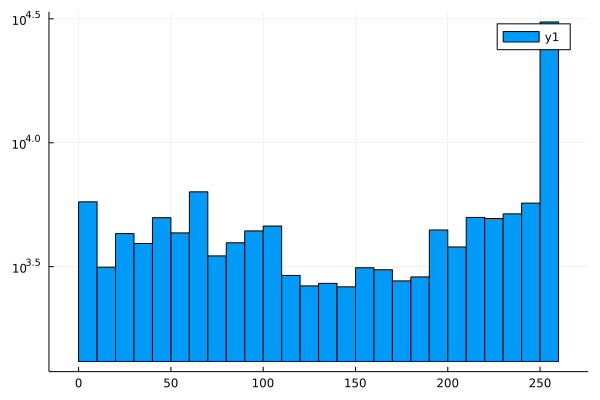

In [12]:
syn_weights = reshape(Array(Float64.(tm.distalSynapses.Dd)), :)

histogram(syn_weights[syn_weights .> 1], yaxis=:log10)

The weights here were stored in UInt8. A nice idea. But this shows the distribution. I think that initially it was uniform.

In [ ]:
function _process_sp(t,tN,data,encParams,sp,display_evaluation=identity)
  # z: encoder activation
  z, bucket= encode_powerDay(data.power_hourly_kw[t], data.hour[t], data.is_weekend[t];
                       encParams...)
  # a: SP activation
  a= step!(sp,z)
  t%(tN÷10)==0 && display_evaluation(t,sp,a,sp.params.szₛₚ)
  return z,a,bucket
end

_process_tm(t,tN, tm,a) = step!(tm,a)

identity(a...) = a

function read_gympower(dataset_filename= "test/test_data/gym_power_benchmark.csv")
  data= CSV.read(dataset_filename, DataFrame)
  ((power_hourly_kw= data.power_hourly_kw,
    hour= data.hour,
    is_weekend= data.is_weekend
   ), size(data,1))
end

"""
Find the top-k% most similar SDRs to the last one from the entire history.
"""
function top_similar_sdr(sdrHist,k)
  k= size(sdrHist,2)==1 ? 0 : ceil(Int,k/100*size(sdrHist,2))
  # Shame: I can't find ANY high-level construct to even approach the efficiency of this!
  overlap= zeros(Int32,size(sdrHist,2)-1)
  for t in 1:length(overlap) for i in 1:size(sdrHist,1)
      overlap[t]+= sdrHist[i,end] & sdrHist[i,t] end end
  topIdx= @> overlap partialsortperm(1:k,rev=true)
  (sdrHist[:,topIdx], topIdx)
end

# Calculate prediction "mean absolute scaled error"
# (https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)
function mase(data,prediction,predict_timesteps)
  aligned_data= data[1+predict_timesteps:end]
  aligned_pred= prediction[1:end-predict_timesteps]
  mean(abs.(aligned_data .- aligned_pred)) / mean(abs.(diff(aligned_data)))
end

plot_ts_similarEncSp(t,ts,encOnly,spOnly,encANDspHistory)=
    if t>1 _plot_ts_similarEncSP(t,ts,encOnly,spOnly,encANDspHistory)
    end

function _plot_ts_similarEncSP(t,ts,encOnly,spOnly,encANDspHistory)
  graph_ts()= begin
    graph_ts= plot(ts, label="power", ylims=(0.9minimum(ts),1.05maximum(ts)),
              xlims=(1,1.3length(ts)))
    scatter!(graph_ts, encOnly, ts[encOnly], label="encoding only")
    scatter!(graph_ts, spOnly, ts[spOnly], label="SP only")
    scatter!(graph_ts, encANDspHistory[t][1], ts[encANDspHistory[t][1]],
              label="overlapping", legendfontsize=6)
    vline!(graph_ts,[t], label="")
    title!(graph_ts, "Spatial Pooler mapping property evaluation", titlefont=font(10))
    return graph_ts
  end
  graph_ovp(overlapFraction)= begin
    graph_ovp= plot(1:t,overlapFraction*100, label="", linestyle=:dash,
        ylabel="overlap%",ylims=(-1,102),xlims=(1,1.3length(ts)))
    title!(graph_ovp, "Percentage of overlapping encoder and SP SDRs", titlefont=font(10))
    return graph_ovp
  end
  overlapFraction= map(x->length(x.encANDsp)/x.Nenc, encANDspHistory[1:t])
  overlapFraction[isnan.(overlapFraction)].= 1.0
  plot(graph_ts(),graph_ovp(overlapFraction), layout=(2,1))|> display
end


In [ ]:
# Parameters for the test script (set in runtests.jl)
#ENV["JULIA_DEBUG"] = "HierarchicalTemporalMemory"
plot_enabled= false

using HierarchicalTemporalMemory, BenchmarkTools, CSV, Printf, Lazy, Test
using Plots; gr()
import Random: seed!, bitrand

using StatsBase: median
seed!(0)

function plot_mase(data, pred, pred_timesteps)
    windowLength= 240
    n = length(data)-windowLength
    errormetric= zeros(n)
    # Compute error for each timepoint over a sliding window
    for w in 1:n
        errormetric[w]= mase(
            data[w:w+windowLength-1], 
            pred[w:w+windowLength-1], 
            pred_timesteps)
    end
    
    # Critical time values
    crit_t1= 1:500
    crit_t2= 3000:3200
    
    # Plots
    p_mase = plot(errormetric, label="10-day MASE")
    p_pred = plot([data pred], label=["timeseries","prediction"], legend=:none)
    p_crit = plot(
                  plot(crit_t1, [data[crit_t1] pred[crit_t1]], legend= :none),
                  plot(crit_t2, [data[crit_t2] pred[crit_t2]], legend= :none),
                  layout= (1,2)
    )
    
    p_all = plot(p_mase, p_pred, p_crit, layout= (3,1))
    display(p_all)
    @info @sprintf("Min 10-day MASE: %.2f\n",minimum(errormetric))
end

display_evaluation(t,sp,sp_activity,spDims)= @info("t=$t")

function process_data!(tN, data, encParams, sp, tm, decoder)
    for t in 1:tN
        # Retrieves something from spaial pooler
        z, a, power_bucket = _process_sp(t, tN, data, encParams, sp, 
                                         display_evaluation)
        # Retrives something from temporal memory
        A, Π, B = _process_tm(t,tN, tm,a)
        # Makes prediction based on neurons in predictive state, Π
        prediction= predict!(decoder,Π,power_bucket)
        # A likelilhood prediction?
        likelyPred= reverse_simpleArithmetic(prediction, "highmean", encParams.power_p)
        # Store everything. I think these are all global!
        history_enc[:,t]= z
        history_SP[:,t]= a
        history_TMout[:,t]= A
        history_TMpred[:,t]= Π
        history_decodedPred[:,t]= prediction
        history_likelyPred[t]= likelyPred
        # Some kind of bursting parameter, I don't know what it is. Update for each t
        global avg_burst= ((t-1)*avg_burst+count(B)/length(B))/t
    end
end

prediction_timesteps=1
inputDims= ((15,6,3).*25,)
spDims= (1600,)
k= 8

@info "creating Spatial Pooler"
sp= SpatialPooler(SPParams(
      szᵢₙ= map(sum,inputDims), szₛₚ=spDims,
      γ=600,
      s=0.03,
      prob_synapse=0.85,
      θ_stimulus_activate=5,
      p⁺_01= 0.20,
      p⁻_01= 0.12,
      β=3,
      Tboost=350,
      enable_local_inhibit=false,
      enable_boosting=true))

@info "creating Temporal Memory"
tm= TemporalMemory(TMParams(
      Nc=prod(spDims),
      k=k,
      θ_stimulus_activate=14,
      θ_stimulus_learn=12,
      synapseSampleSize=35,
      p⁺_01=0.24,
      p⁻_01=0.08,
      LTD_p⁻_01= 0.012
     ))

# Number of columns
Ncol= prod(spDims); 
# Number of cells
Ncell= Ncol*k
# Define input data
data,tN= read_gympower(test_dir * "test_data/gym_power_benchmark-extended.csv")

# Creates encoder
encParams= initenc_powerDay(data.power_hourly_kw, data.hour, data.is_weekend,
                            encoder_size=inputDims[1], w=(34,35,35))

# Creates decoding classifier
decoder= SDRClassifier(Ncell, encParams.power_p.buckets,
                       α=0.09, buffer_length=prediction_timesteps)

# Initialize empty histories
history_enc= falses(map(sum,inputDims)|>prod,tN)
history_SP= falses(Ncol,tN)
history_TMout=  falses(Ncell,tN)
history_TMpred= falses(Ncell,tN)
history_decodedPred= zeros(encParams.power_p.buckets,tN)
history_likelyPred= zeros(tN)
avg_burst= 0

# Does all training occur in here? I'd better grab it.
process_data!(tN,data,encParams,sp,tm,decoder)

errormetric= mase(data.power_hourly_kw[400:end], history_likelyPred[400:end],prediction_timesteps)
@info @sprintf("Prediction MASE: %.3f\n", errormetric)

avg_TMout_sparsity= mapslices(x->count(x)./length(x),history_TMout,dims=1)'|>median
plot_enabled && plot_mase(data.power_hourly_kw, history_likelyPred, prediction_timesteps)
@info @sprintf("avg_TMout_sparsity: %.3f%%\n", 100*avg_TMout_sparsity)
@info @sprintf("avg_burst: %.3f%%\n", 100*avg_burst)

# Sanity check: If this is not true, there's something very wrong with the temporal memory
@test errormetric < 1.15